# Process gridded observation data into timeseries

## 2024/08/20

Just do 5x5 data.

__1. Process the gridded temperature data into timeseries for each observational product.__

Output is a dataArray for each model with dimensions of time and IPCC region containing a time series of the TAS variable.


Use this tool:  

https://github.com/IPCC-WG1/Atlas/blob/main/notebooks/reference-regions_Python.ipynb

For now, I will create my code for the CESM1 and MPI models so that it can be generalized easily. I can pull some code from my climatetrend_uncertainty repository (climatetrend_uncertainty/initial_code/PIC_timeseries_preproc.ipynb).

## Code!

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

import xagg as xa
import geopandas as gpd
import regionmask

regionmask.__version__

%matplotlib inline

__Observational Large Ensembles.__

General directory in Nathan's scratch: /glade/scratch/lenssen/data_for_jonah/

NASA GISTEMP: GISTEMP_2x2  GISTEMP_5x5

HadCRUT5: HadCRUT5

In [2]:
gistemp_2x2_dir = '/glade/derecho/scratch/lenssen/data4jonah/GISTEMP_Ensemble_Aug/' # I don't want to use this
gistemp_dir = "/glade/derecho/scratch/lenssen/data4jonah/GISTEMP_Ensemble_Aug_5x5/"
hadcrut5_dir = '/glade/derecho/scratch/lenssen/data4jonah/HadCRUT5_Ensemble_Aug/'

### Collect file paths.

#### Collect GISTEMP file paths.

In [3]:
gistemp_files = glob.glob('%s/ensembleChunk_5x5_????.nc' % gistemp_dir)
gistemp_files.sort()

#### Collect HadCRUT5 file paths.

In [4]:
hadcrut5_files = glob.glob('%s/HadCRUT.5.0.2.0.analysis.anomalies.*.nc' % hadcrut5_dir)
hadcrut5_files.sort()

### Load and process timeseries according to IPCC Region designations.

Mask data based on availability.

In [5]:
# gistemp_files[0]

In [6]:
# # Create mask based on data availability. Then I will need to apply it to mask the averaged data before saving.
# test_file = gistemp_files[0]
# test_var = "tas"

# masking_threshold = 0.9 # 90% of a region must be available

# ds = xr.open_dataset(test_file)
# da = ds[test_var]a

# mask    = regions.mask(da.isel(time=0))

# # Get unique region indices
# reg     = np.unique(mask.values)
# reg     = reg[~np.isnan(reg)]

# # for metadata: find abbreviations of all regions that were selected
# abbrevs = regions[reg].abbrevs
# names   = regions[reg].names

# # Compute weights for entire grid
# weights_spatial = np.cos(np.deg2rad(da.lat)).broadcast_like(da.isel(time=0)) # assuming 'lat' used consistently
# weights_spatiotemporal = np.cos(np.deg2rad(da.lat)).broadcast_like(da) # assuming 'lat' used consistently

# # Iterate over regions and compute a weighted time series
# region_masks_list = []
# for i,_abbrev,_name in zip(reg, abbrevs, names):
    
#     _region_weight = weights_spatial.where(mask == i).sum(dim=["lat", "lon"]) # Total weight of the region
#     _available_region_weights = weights_spatiotemporal.where((mask == i) & (~np.isnan(da))).sum(dim=["lat", "lon"]) # Weight of the unmasked portion of the region
    
#     _region_mask = (_available_region_weights / _region_weight) > masking_threshold
#     _region_mask = _region_mask.assign_coords(RegionIndex=i).expand_dims("RegionIndex")
#     _region_mask = _region_mask.assign_coords(RegionName=_name)
#     _region_mask = _region_mask.assign_coords(RegionAbbrev=_abbrev)
    
#     region_masks_list.append(_region_mask)
# region_masks = xr.concat(region_masks_list, dim="RegionIndex")


In [7]:
# testmask = mask_IPCC_byavailability(
#     filepath=gistemp_files[0],
#     var="tas",
#     regions=regionmask.defined_regions.ar6.all,
#     masking_threshold=0.9,
#     ufunc=gistemp_5x5_preproc,
# )

In [8]:
# testmask.sum(dim="RegionIndex").plot()

In [9]:
# testmask.sel(time="1901-07-11")

In [10]:
# testmask.sel(RegionIndex=22).plot()

In [11]:
# # Ok, yeah so a lot of regions might be missing for this. 
# # Not sure why it doesn't match up well with the plots I made earlier,
# # perhaps because this is just one ensemble member that may be conservative?
# np.isnan(ds["tas"]).any(dim="time").plot()

In [12]:
# # Ok this makes sense now given the map, but have I made a mistake earlier?
# for i in (~region_masks).any(dim="time"):
#     print(f"Region: {i.RegionName.values} {bool(i.values)}" )
#     #.plot()

#### 1. Visualize the IPCC AR6 regions

### 2. Do masking for each dataset

Variable is "tempAnom". "record" coordinate will allow for easier concatenation.

In [13]:
gistemp_tas_var = 'tas'
hadcrut5_tas_var = 'tas'

### Loop over observation files and compute the regional means.

#### GISTEMP

In [14]:
def create_ipccregion_timeseries_xagg(
    ds_filepath:str,
    ds_var:str,
    model_str:str,
    cesm=False,
    read_wm=True,
    write_wm=True,
):
    
    '''
    Compute timeseries for all IPCC AR6 regions when given a simple model output file.
    Now using xagg to appropriately weight gridcells that fall partly within a region!
    '''
    # Load data
    ds = xr.open_dataset(ds_filepath)
    
    try:
        ds = ds.rename({"latitude":"lat", "longitude":"lon"})
    except:
        pass
    
    # Correct time if CESM
    if cesm:
        ds  = fix_cesm_time(ds)
    
    da = ds[ds_var]

    xagg_dir = "/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/xagg_resources"
    xa.set_options(rgrd_alg='bilinear',nan_to_zero_regridding=False)

    if (read_wm and os.path.exists(os.path.join(xagg_dir, f'wm_{model_str}'))):
        # Load weightmap
        weightmap = xa.read_wm(os.path.join(xagg_dir, f'wm_{model_str}'))
    else:
        # Load IPCC region shp file:
        ipcc_wgi_regions_shp = "IPCC-WGI-reference-regions-v4.shp"
        gdf = gpd.read_file(os.path.join(xagg_dir, ipcc_wgi_regions_shp))
                
        # Compute weights for entire grid. Assuming lat, lon, time dimension on input
        area_weights = np.cos(np.deg2rad(da.lat)).broadcast_like(da.isel(time=0).squeeze())
        
        weightmap = xa.pixel_overlaps(da, gdf, weights=area_weights)
        # Save the weightmap for later:
        if write_wm:
            weightmap.to_file(os.path.join(xagg_dir, f'wm_{model_str}'))

    # Aggregate
    with xa.set_options(silent=True):
        aggregated = xa.aggregate(da, weightmap)
    # aggregated = xa.aggregate(da, weightmap)
    
    # Convert to an xarray dataset
    aggregated_ds = aggregated.to_dataset()
    # Change xarray formatting to match previous file organization.
    aggregated_ds = aggregated_ds.set_coords(("Continent", "Type", "Name", "Acronym")).rename({"poly_idx": "RegionIndex", "Name": "RegionName", "Acronym": "RegionAbbrev"})
        
    return aggregated_ds

In [15]:
def mask_IPCC_byavailability(
    filepath: str,
    var: str,
    regions: regionmask.Regions,
    masking_threshold: float=0.9,
    ufunc=None,
):
    """
    Function for masking observational record according to data availability.
    True on the output means that region exceeds the threshold.

    Args:
        filepath (str): Path to file to load
        var (str): String identifier of variable to mask by availabiliy
        masking_threshold (float, optional): Fraction of region needed to avoid masking. Defaults to 0.9.
        ufunc (function, optional): Function to apply to the loaded DataArray. Defaults to None.

    Returns:
        region_masks (xr.DataArray): Boolean mask for each IPCC region
    """

    ds = xr.open_dataset(filepath)

    da = ds[var]
    if ufunc is not None:
        da = ufunc(da)

    mask    = regions.mask(da.isel(time=0))

    # Get unique region indices
    reg     = np.unique(mask.values)
    reg     = reg[~np.isnan(reg)]

    # for metadata: find abbreviations of all regions that were selected
    abbrevs = regions[reg].abbrevs
    names   = regions[reg].names

    # Compute weights for entire grid
    weights_spatial = np.cos(np.deg2rad(da.lat)).broadcast_like(da.isel(time=0)) # assuming 'lat' used consistently
    weights_spatiotemporal = np.cos(np.deg2rad(da.lat)).broadcast_like(da) # assuming 'lat' used consistently

    # Iterate over regions and compute a weighted time series
    region_masks_list = []
    for i,_abbrev,_name in zip(reg, abbrevs, names):
        
        _region_weight = weights_spatial.where(mask == i).sum(dim=["lat", "lon"]) # Total weight of the region
        _available_region_weights = weights_spatiotemporal.where((mask == i) & (~np.isnan(da))).sum(dim=["lat", "lon"]) # Weight of the unmasked portion of the region
        
        _region_mask = (_available_region_weights / _region_weight) > masking_threshold
        _region_mask = _region_mask.assign_coords(RegionIndex=i).expand_dims("RegionIndex")
        _region_mask = _region_mask.assign_coords(RegionName=_name)
        _region_mask = _region_mask.assign_coords(RegionAbbrev=_abbrev)
        
        region_masks_list.append(_region_mask)
    region_masks = xr.concat(region_masks_list, dim="RegionIndex")
    region_masks.name = "mask"
    
    return region_masks


def gistemp_5x5_preproc(ds):
    
    return ds.rename({"latitude":"lat", "longitude":"lon"})

In [16]:
# def create_ipccregion_timeseries(_ds_filepath:str,_ds_var:str,regions:regionmask.Regions,cesm=False,ufunc=None,
#                                  lon=None,lat=None,lon_name='lon',lat_name='lat'):
    
#     '''
#     Compute timeseries for all IPCC AR6 regions when given a simple model output file.
#     '''
#     # Load data
#     ds      = xr.open_dataset(_ds_filepath,chunks={lat_name:-1,lon_name:-1})
    
#     # Correct time if CESM
#     if cesm:
#         ds  = fix_cesm_time(ds)
    
#     da      = ds[_ds_var]
    
#     if (ufunc is not None):
#         da = ufunc(da) #.sel(time=slice(1960,None))
#     # da = da.chunk(chunks={'lat':-1,'lon':-1,'record':1}) # JKS speed-up attempt
    
#     # Generate mask
#     if ((lon is not None) and (lat is not None)):
#         print('Using "lat" and "lon" supplied as input')
        
#         # Make sure the passed grid values match the data approximately.
#         np.testing.assert_allclose(lat,da['lat'],atol=5e-2,rtol=1e-1,err_msg='Supplied latitudes do not match data')
#         np.testing.assert_allclose(lon,da['lon'],atol=5e-2,rtol=1e-1,err_msg='Supplied longitudes do not match data')
        
#         mask    = regions.mask(lon,lat=lat)
        
#         da['lon'] = lon
#         da['lat'] = lat
        
#     else:
#         mask    = regions.mask(da)
    
#     # Get unique region indices
#     reg     = np.unique(mask.values)
#     reg     = reg[~np.isnan(reg)]
    
#     # for metadata: find abbreviations of all regions that were selected
#     abbrevs = regions[reg].abbrevs
#     names   = regions[reg].names
    
#     # Compute weights for entire grid
#     weights = np.cos(np.deg2rad(da.lat)) # assuming 'lat' used consistently
    
#     # Iterate over regions and compute a weighted time series
#     region_timeseries = []
#     for i,_abbrev,_name in zip(reg,abbrevs,names):
        
#         _region = da.where(mask == i)
        
#         _region_avg = _region.weighted(weights).mean(dim=("lat", "lon")) # - 273.15
                
#         # Using an int here should help with subsetting later.
#         _region_avg = _region_avg.assign_coords({'RegionIndex':int(i)}).expand_dims('RegionIndex',axis=-1)

#         # Include region abbreviation and name for easier use later
#         _region_avg = _region_avg.assign_coords({'RegionAbbrev':_abbrev})
#         _region_avg = _region_avg.assign_coords({'RegionName':_name})
        
#         region_timeseries.append(_region_avg)
        
#     region_timeseries_ds = xr.concat(region_timeseries,dim='RegionIndex')
#     region_timeseries_ds.name = _ds_var
        
#     return region_timeseries_ds

In [17]:
# # Arbitrary function to apply

# def gistemp_5x5_tselect(da:xr.DataArray):
    
#     # return da.sel(time=slice("1900-01-01",'2022-12-31')).rename({'longitude':'lon','latitude':'lat'})
#     return da.sel(time=slice(None, '2022-12-31')).rename({'longitude':'lon','latitude':'lat'})

In [18]:
# standard_test = create_ipccregion_timeseries(
#     _ds_filepath=gistemp_files[0],
#     _ds_var=gistemp_tas_var,
#     regions=regionmask.defined_regions.ar6.all,
#     cesm=False,
#     ufunc=gistemp_5x5_tselect,
#     lon_name='longitude',
#     lat_name='latitude',
# )

In [19]:
# ipcc_regions_maskedavail = xagg_test.where(avail_mask)

In [20]:
# ipcc_regions_maskedavail["tas"].sel(RegionIndex=44).plot()
# xagg_test["tas"].sel(RegionIndex=44).plot()

In [21]:
# xagg_test = create_ipccregion_timeseries_xagg(
#     ds_filepath=gistemp_files[0],
#     ds_var=gistemp_tas_var,
#     model_str="GISTEMP_5x5",
#     cesm=False,
# )

# avail_mask = mask_IPCC_byavailability(
#     filepath=gistemp_files[0],
#     var=gistemp_tas_var,
#     regions=regionmask.defined_regions.ar6.all,
#     masking_threshold=0.9,
#     ufunc=gistemp_5x5_preproc,
# )

# ipcc_regions_maskedavail = xagg_test.where(avail_mask)

In [22]:
# fig, axs = plt.subplots(1, 2, figsize=(12,6))
# axs = axs.flat

# xagg_test["tas"].isel(time=0).plot(label="xagg", ax=axs[0])
# standard_test.isel(time=0).plot(label="RegionMask", ax=axs[0])

# xagg_test["tas"].isel(time=-1).plot(label="xagg", ax=axs[1])
# standard_test.isel(time=-1).plot(label="RegionMask", ax=axs[1])

# plt.legend()

In [23]:
save_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/'

#### GISTEMP

In [38]:
%%time

# gistemp_new_times = (pd.date_range("1900-01-01", freq="1M", periods=12*61)-pd.offsets.MonthBegin(1)).shift(periods=14,freq='D')
model_subdir = 'GISTEMP_5x5/20240820/xagg/'

if not os.path.exists(os.path.join(save_dir,model_subdir)):
    os.makedirs(os.path.join(save_dir,model_subdir))

# Variable to select and operate over.
_ds_var = gistemp_tas_var

for i,_ds_filepath in enumerate(gistemp_files):
    # break
    xagg_region_means = create_ipccregion_timeseries_xagg(
        ds_filepath=_ds_filepath,
        ds_var=_ds_var,
        model_str="GISTEMP_5x5",
        cesm=False,
    )

    avail_mask = mask_IPCC_byavailability(
        filepath=_ds_filepath,
        var=gistemp_tas_var,
        regions=regionmask.defined_regions.ar6.all,
        masking_threshold=0.9,
        ufunc=gistemp_5x5_preproc,
    )

    ipcc_regions_maskedavail = xagg_region_means.where(avail_mask)
    
    # Add "realization" coordinate so concatenation is easier.
    ipcc_regions_maskedavail = ipcc_regions_maskedavail.assign_coords(realization=i+1).expand_dims("realization")
    
    filename = _ds_filepath.split('/')[-1]
    
    _outfilepath = '%s/%s/%s' % (save_dir,model_subdir,filename)
    print(_outfilepath)
    
    # break
    ipcc_regions_maskedavail.to_netcdf(path=_outfilepath)
    if i == 2: break
    
    

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xagg/core.py:724: UserWarning: One or more of the pixels in variable tas have nans in them in the dimensions time. The code can currently only deal with pixels for which the *entire* pixel has nan values in all dimensions, however there is currently no  support for data in which pixels have only some nan values. The aggregation calculation is likely incorrect.
  warnings.warn('One or more of the pixels in variable '+var+' have nans in them in the dimensions '+
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xagg/core.py:724: UserWarning: One or more of the pixels in variable tas have nans in them in the dimensions time. The code can currently only deal with pixels for which the *entire* pixel has nan values in all dimensions, however there is currently no  support for data in which pixels have only some nan values. The aggregation calculation is likely incorrect.
  warnings.warn('One or more of 

/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_5x5/20240820/xagg//ensembleChunk_5x5_0001.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xagg/core.py:724: UserWarning: One or more of the pixels in variable tas have nans in them in the dimensions time. The code can currently only deal with pixels for which the *entire* pixel has nan values in all dimensions, however there is currently no  support for data in which pixels have only some nan values. The aggregation calculation is likely incorrect.
  warnings.warn('One or more of the pixels in variable '+var+' have nans in them in the dimensions '+
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xagg/core.py:724: UserWarning: One or more of the pixels in variable tas have nans in them in the dimensions time. The code can currently only deal with pixels for which the *entire* pixel has nan values in all dimensions, however there is currently no  support for data in which pixels have only some nan values. The aggregation calculation is likely incorrect.
  warnings.warn('One or more of 

/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_5x5/20240820/xagg//ensembleChunk_5x5_0002.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xagg/core.py:724: UserWarning: One or more of the pixels in variable tas have nans in them in the dimensions time. The code can currently only deal with pixels for which the *entire* pixel has nan values in all dimensions, however there is currently no  support for data in which pixels have only some nan values. The aggregation calculation is likely incorrect.
  warnings.warn('One or more of the pixels in variable '+var+' have nans in them in the dimensions '+
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xagg/core.py:724: UserWarning: One or more of the pixels in variable tas have nans in them in the dimensions time. The code can currently only deal with pixels for which the *entire* pixel has nan values in all dimensions, however there is currently no  support for data in which pixels have only some nan values. The aggregation calculation is likely incorrect.
  warnings.warn('One or more of 

/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_5x5/20240820/xagg//ensembleChunk_5x5_0003.nc
CPU times: user 6.59 s, sys: 4.24 s, total: 10.8 s
Wall time: 11.2 s


In [22]:
ex_gistemp_5x5_tseries = _regional_tseries

#### HadCRUT5

In [31]:
# # Arbitrary function to apply

# def hadcrut5_tselect(da:xr.DataArray):
    
#     return da.sel(time=slice('1900-01-01','2022-12-31')).rename({'longitude':'lon','latitude':'lat'})

In [ ]:
# Arbitrary function to apply

def hadcrut5_preproc(da:xr.DataArray):
    
    return da.rename({'longitude':'lon','latitude':'lat'})

In [32]:
%%time

model_subdir = 'HadCRUT5/20240820/xagg'

if not os.path.exists(os.path.join(save_dir,model_subdir)):
    os.makedirs(os.path.join(save_dir,model_subdir))

# Variable to select and operate over.
_ds_var = hadcrut5_tas_var

for _ds_filepath in hadcrut5_files:

    _regional_tseries_delayed = create_ipccregion_timeseries(_ds_filepath=_ds_filepath,
                                                             _ds_var=_ds_var,
                                                             regions=regionmask.defined_regions.ar6.all,
                                                             cesm=False,
                                                             ufunc=hadcrut5_tselect,
                                                             lon_name='longitude',
                                                             lat_name='latitude',
                                                            )
    _regional_tseries = _regional_tseries_delayed.compute()
    _regional_tseries = _regional_tseries.expand_dims('realization')
    
    filename = _ds_filepath.split('/')[-1]
    
    _outfilepath = '%s/%s/%s' % (save_dir,model_subdir,filename)
    
    _regional_tseries.to_netcdf(path=_outfilepath)
    
    print(_outfilepath)
    
    # break

/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//HadCRUT5/20240820//HadCRUT.5.0.2.0.analysis.anomalies.1.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//HadCRUT5/20240820//HadCRUT.5.0.2.0.analysis.anomalies.10.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//HadCRUT5/20240820//HadCRUT.5.0.2.0.analysis.anomalies.100.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//HadCRUT5/20240820//HadCRUT.5.0.2.0.analysis.anomalies.101.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//HadCRUT5/20240820//HadCRUT.5.0.2.0.analysis.anomalies.102.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//HadCRUT5/20240820//HadCRUT.5.0.2.0.analysis.anomalies.103.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//HadCRUT5/20240820//HadCRUT.5.0.2.0.analysis.anomalies.104.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//HadCRUT5/20240820//HadCRUT.5.0.2.0.analysis.anomalies.105.nc
/glade/u/home/jonahshaw/w/t

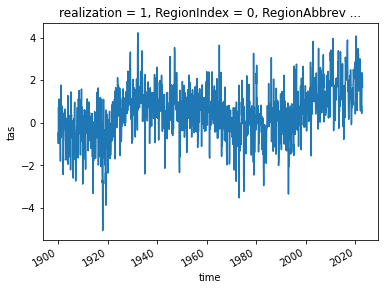

In [20]:
_regional_tseries.isel(RegionIndex=0).plot()

In [27]:
ex_hadcrut5_tseries = _regional_tseries

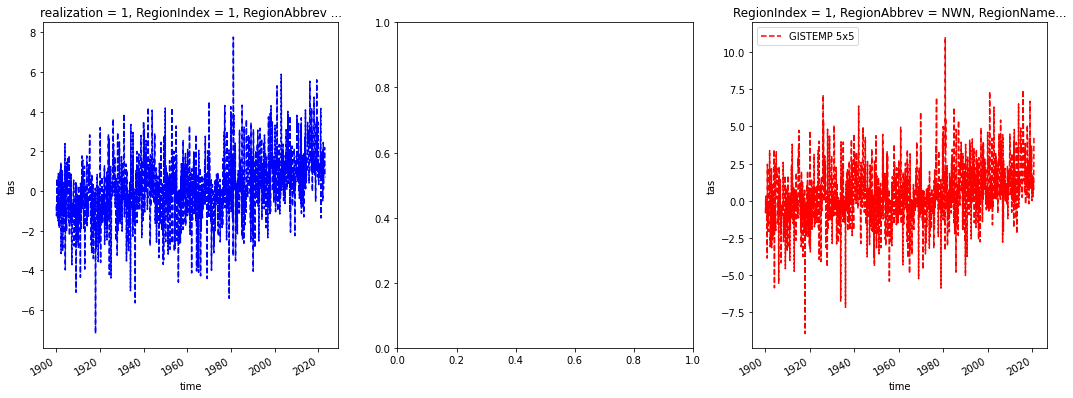

In [29]:
fig,axs = plt.subplots(1,2,figsize=(12,6))

region_index = 1

ex_hadcrut5_tseries.sel(RegionIndex=region_index).plot(color='blue',label='HadCRUT5',linestyle='dashed',ax=axs[0])

ex_gistemp_5x5_tseries.sel(RegionIndex=region_index).isel(realization=0).plot(color='red',label='GISTEMP 5x5',linestyle='dashed',ax=axs[1])

plt.legend()